In [186]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
import optuna
import logging


In [164]:
class XOutlierRemover:
    def __init__(self):
        self.boundaries_X = {}

    def fit(self, X_train):
        for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.boundaries_X[col] = (lower_bound, upper_bound)

        return self

    def transform(self, X, y):
        mask_X = np.ones(X.shape[0], dtype=bool)

        X.reset_index(drop=True)
        y.reset_index(drop=True)

        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            if col in self.boundaries_X:
                lower_bound, upper_bound = self.boundaries_X[col]
                mask_X &= (X[col] >= lower_bound) & (X[col] <= upper_bound)
            
            X.reset_index(drop=True)
            y.reset_index(drop=True)

            X_filtered = X[mask_X].reset_index(drop=True)
            y_filtered = y[mask_X].reset_index(drop=True)

        return X_filtered, y_filtered

In [188]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingRegressor()):
        self.model = model
        self.numerical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()
        self.numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
        valid_columns = []
        for col in self.numerical_columns:
            unique_vals = set(X[col].dropna())
            if len(unique_vals) > 2 or unique_vals != {0, 1}:
                valid_columns.append(col)
        self.numerical_columns = valid_columns
        for col in self.numerical_columns:
            if X[col].isna().sum() > 0:
                X_features = X[self.numerical_columns].drop(columns=[col])
                mask = X[col].notna()
                X_train = X_features.loc[mask]
                y_train = X.loc[mask, col]
                if len(X_train) > 10:
                    model = clone(self.model)
                    model.fit(X_train, y_train)
                    self.models[col] = model
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, model in self.models.items():
            mask = X_copy[col].isna()
            if mask.sum() == 0:
                continue
            X_features = X_copy[self.numerical_columns].drop(columns=[col])
            X_missing = X_features.loc[mask]
            predicted = model.predict(X_missing)
            X_copy.loc[mask, col] = predicted
        return X_copy


In [189]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingClassifier()):
        self.model = model
        self.categorical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()
        self.categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        valid_columns = []
        for col in self.categorical_columns:
            unique_vals = set(X[col].dropna())
            if len(unique_vals) > 2:
                valid_columns.append(col)
        self.categorical_columns = valid_columns
        for col in self.categorical_columns:
            if X[col].isna().sum() > 0:
                X_features = X[self.categorical_columns].drop(columns=[col])
                mask = X[col].notna()
                X_train = X_features.loc[mask]
                y_train = X.loc[mask, col]
                if len(X_train) > 10:
                    model = clone(self.model)
                    model.fit(X_train, y_train)
                    self.models[col] = model
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, model in self.models.items():
            mask = X_copy[col].isna()
            if mask.sum() == 0:
                continue
            X_features = X_copy[self.categorical_columns].drop(columns=[col])
            X_missing = X_features.loc[mask]
            predicted = model.predict(X_missing)
            X_copy.loc[mask, col] = predicted
        return X_copy


In [171]:
def evaluate_model(model, X_train, y_train, n_splits=3, seed=42):
    scores = []
    imputers = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx].copy()
        y_val = y_train.iloc[val_idx].copy()


        num_imputer = NumericalImputer().fit(X_tr)
        X_tr = num_imputer.transform(X_tr)
        X_val = num_imputer.transform(X_val)

          # onehotencoder
            # scalling

        if (np.any(np.isnan(X_tr)) or np.any(np.isinf(X_tr)) or
            np.any(np.isnan(X_val)) or np.any(np.isinf(X_val)) or
            np.any(np.isnan(y_tr)) or np.any(np.isinf(y_tr)) or
            np.any(np.isnan(y_val)) or np.any(np.isinf(y_val))):
            print("⚠️ NaN/inf")
            continue

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = r2_score(y_val, preds)
        scores.append(score)
        imputers.append(num_imputer)

    if not scores:
        print("⚠️")
        return float("-inf"), None

    return np.mean(scores), imputers[-1]

In [103]:
import xgboost as xgb
import numpy as np

def objective(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "tree_method": "hist", 
        "random_state": 42,
        "verbosity": 0,
        "n_jobs": -1 
    }

    print(f"Testing trial with params: {params}")

    try:
        model = xgb.XGBRegressor(**params)

        numerical_columns = X_train.select_dtypes(include=["number"]).columns

        score, imputers = evaluate_model(model, X_train, y_train, n_splits=3)

        if np.isnan(score) or np.isinf(score):
            print(f"[Trial {trial.number}] Invalid score: {score}")
            return float("-inf")

        trial.set_user_attr("model", model)
        trial.set_user_attr("imputers", imputers)

        print(f"[Trial {trial.number}] Done with score: {score}")
        return score

    except Exception as e:
        print(f"[Trial {trial.number}] Error: {e}")
        return float("-inf")


In [104]:
def remove_percentage_and_convert_column(df, column_name):
    df[column_name] = df[column_name].replace({'%': ''}, regex=True).astype(float) / 100
    return df

In [105]:
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    
    if isinstance(date_str, float):
        return int(date_str)
    
    if isinstance(date_str, str):
        try:
            if "/" in date_str:
                return int(date_str.split("/")[-1])
            elif "-" in date_str:
                return int(date_str.split("-")[0])
            else:
                raise ValueError(f"Unknown date format: {date_str}")
        except Exception as e:
            print(f"Error processing date: {e}")
            return None
    else:
        return None


In [106]:

pd.set_option('display.max_columns', None)

In [107]:

df = pd.read_csv("listings.csv", encoding="utf-8")


In [14]:

print(df.head())

       id                          listing_url       scrape_id last_scraped  \
0   23163   https://www.airbnb.com/rooms/23163  20250316041547   2025-03-16   
1   23169   https://www.airbnb.com/rooms/23169  20250316041547   2025-03-16   
2   26755   https://www.airbnb.com/rooms/26755  20250316041547   2025-03-16   
3  782440  https://www.airbnb.com/rooms/782440  20250316041547   2025-03-16   
4  782489  https://www.airbnb.com/rooms/782489  20250316041547   2025-03-16   

        source                                 name  \
0  city scrape         Residence Karolina - KAROL12   
1  city scrape           Residence Masna - Masna302   
2  city scrape    Central Prague Old Town Top Floor   
3  city scrape  Central,Cheap&Lovely Miniapartment2   
4  city scrape  Central,Cheap&Lovely Miniapartment3   

                                         description  \
0  Unique and elegant apartment rental in Prague,...   
1  Masna studio offers a lot of space and privacy...   
2  Big and beautiful new a

In [108]:
df["price"] = df["price"].replace(r"[\$,]", "", regex=True).astype(float)

In [109]:
print(df.describe(include="all"))

                  id                         listing_url     scrape_id  \
count   1.010800e+04                               10108  1.010800e+04   
unique           NaN                               10108           NaN   
top              NaN  https://www.airbnb.com/rooms/23163           NaN   
freq             NaN                                   1           NaN   
mean    6.108089e+17                                 NaN  2.025032e+13   
std     5.380318e+17                                 NaN  3.906443e-03   
min     2.316300e+04                                 NaN  2.025032e+13   
25%     3.280956e+07                                 NaN  2.025032e+13   
50%     7.446005e+17                                 NaN  2.025032e+13   
75%     1.128376e+18                                 NaN  2.025032e+13   
max     1.376688e+18                                 NaN  2.025032e+13   

       last_scraped       source                              name  \
count         10108        10108         

In [110]:
df.drop_duplicates()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,23163,https://www.airbnb.com/rooms/23163,20250316041547,2025-03-16,city scrape,Residence Karolina - KAROL12,"Unique and elegant apartment rental in Prague,...",NaN,https://a0.muscache.com/pictures/01bbe32c-3f13...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.082290,14.415520,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,2.0,"[""Coffee maker"", ""Dishwasher"", ""Bed linens"", ""...",2918.0,1,365,1,7,60,731,1.4,663.6,NaN,t,0,0,0,0,2025-03-16,31,1,0,0,1,6,17508.0,2010-09-20,2024-06-15,4.90,4.83,5.00,5.00,4.97,4.93,4.86,NaN,t,70,69,0,0,0.18
1,23169,https://www.airbnb.com/rooms/23169,20250316041547,2025-03-16,city scrape,Residence Masna - Masna302,Masna studio offers a lot of space and privacy...,NaN,https://a0.muscache.com/pictures/b450cf2a-8561...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.088300,14.422720,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Patio or balcony"", ""Coffee maker"", ""Bed line...",NaN,1,365,1,7,60,731,1.2,710.6,NaN,t,7,13,13,13,2025-03-16,122,6,0,13,8,36,NaN,2010-05-07,2024-11-08,4.74,4.60,4.83,4.81,4.87,4.97,4.70,NaN,t,70,69,0,0,0.67
2,26755,https://www.airbnb.com/rooms/26755,20250316041547,2025-03-16,city scrape,Central Prague Old Town Top Floor,Big and beautiful new attic apartment in the v...,This apartment offers a fantastic location. Yo...,https://a0.muscache.com/pictures/miso/Hosting-...,113902,https://www.airbnb.com/users/show/113902,Daniel+Bea,2010-04-26,"Prague, Czechia",Hi! we are a sp/cz couple with 2 daughters (La...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/8db01...,https://a0.muscache.com/im/pictures/user/8db01...,Staré Město,4.0,4.0,"['email', 'phone']",t,t,"Prague, Hlavní město Praha, Czechia",Praha 1,NaN,50.087290,14.431790,Entire rental unit,Entire home/apt,4,1.5,1.5 baths,1.0,2.0,"[""AC - split type ductless system"", ""Coffee ma...",1582.0,3,700,3,4,1125,1125,3.1,1125.0,NaN,t,3,7,24,173,2025-03-16,411,53,3,173,57,255,403410.0,2015-05-19,2025-03-07,4.94,4.95,4.92,4.93,4.96,4.93,4.90,NaN,f,3,3,0,0,3.43
3,782440,http

In [54]:
print(df.isnull().sum())

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               975
Length: 79, dtype: int64


In [111]:
df["price"].describe()

count      8808.000000
mean       2730.524977
std        8349.628162
min         223.000000
25%        1242.750000
50%        1762.000000
75%        2641.000000
max      251025.000000
Name: price, dtype: float64

In [56]:
import seaborn as sns


corr_matrix = df.corr()


plt.figure(figsize=(15, 12))


sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

plt.show()

/var/folders/c2/5t4vwc1n1jdcwd15x4d_69cm0000gn/T/ipykernel_89860/3578779041.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


KeyboardInterrupt: 

In [112]:
df["neighbourhood"]

0                                         NaN
1                                         NaN
2         Prague, Hlavní město Praha, Czechia
3                                         NaN
4                                         NaN
                         ...                 
10103                                     NaN
10104                                     NaN
10105                                     NaN
10106                                     NaN
10107    Praha 1, Hlavní město Praha, Czechia
Name: neighbourhood, Length: 10108, dtype: object

In [113]:
#"first_review", "last_review", 
drop_cols = [ "id", "name", "description", "license", "host_id", "host_name", "host_about", "neighborhood_overview", "neighbourhood_group_cleansed",
            "listing_url", "calendar_updated", "scrape_id", "last_scraped", "host_thumbnail_url", "neighbourhood", "listing_url", "picture_url", "host_url", "host_picture_url", "latitude","longitude"
    ]

In [ ]:
# drop_cols = id, listing_url, scrape_id, last_scraped, description, neighborhood_overview, picture_url, host_url, host_about,

#  host_thumbnail_url, host_picture_url, neighbourhood, neighbourhood_group_cleansed, latitude, longitude,

#  calendar_updated, license

In [114]:
df["first_review"].isna().sum()


975

In [115]:
#could make new columns from this column for instance: coffee machine 1/0
transform_columns = ["amenities"]

In [124]:
#host_thumbnail_url possibly getting user?
# "host_verifications", "host_has_profile_pic", host_identity_verified, has_availability, "instant_bookable"  binary
cat_columns = [ "host_url", "host_is_superhost", "host_verifications", "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed" " property_type", "room_type", "bathrooms_text", "has_availability", "instant_bookable", "host_verifications", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"
    ]

In [125]:
#needs to be transformed to integer
perc_col = ["host_response_rate", "host_acceptance_rate"]

In [126]:
df = df.drop(columns = drop_cols, axis = 1)

In [127]:
#could include more old prices since its previous scrape
df["host_response_rate"]

0        100%
1        100%
2        100%
3        100%
4        100%
         ... 
10103     94%
10104    100%
10105     NaN
10106    100%
10107    100%
Name: host_response_rate, Length: 10108, dtype: object

In [128]:
for column in perc_col:
    df = remove_percentage_and_convert_column(df, column)

In [129]:
df['host_since'] = df['host_since'].apply(extract_year)
df['host_since'] = df['host_since'].astype('float64')
df['host_since']

0        2008.0
1        2008.0
2        2010.0
3        2012.0
4        2012.0
          ...  
10103    2019.0
10104    2015.0
10105    2025.0
10106    2021.0
10107    2010.0
Name: host_since, Length: 10108, dtype: float64

In [130]:

new_columns =[
    "Coffee maker", "Bed linens", "Shampoo", "Heating", "Wifi",
    "Dishwasher", "Washer", "Wine glasses", "Pets allowed", "Patio or balcony"
]

for feature in new_columns:
    df[feature] = df['amenities'].apply(lambda x: 1 if feature in x else 0)

df = df.drop("amenities", axis=1)
df.columns

Index(['source', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', '

In [131]:
for feature in new_columns:
    df[feature] = df[feature].astype('category')

In [141]:
numerical_columns = df.select_dtypes(include=["number"]).columns
# Odebereme sloupec "price"
numerical_columns = numerical_columns.drop("price", errors="ignore")
for col in numerical_columns:

    df[col] = df[col].astype('float64')

categorical_columns = df.select_dtypes(include=["object", "category"]).columns
categorical_columns = categorical_columns.drop("price", errors="ignore")
categorical_columns

Index(['source', 'host_location', 'host_response_time', 'host_is_superhost',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'instant_bookable', 'Coffee maker', 'Bed linens', 'Shampoo', 'Heating',
       'Wifi', 'Dishwasher', 'Washer', 'Wine glasses', 'Pets allowed',
       'Patio or balcony'],
      dtype='object')

In [68]:


fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 5 * len(numerical_columns)))


if len(numerical_columns) == 1:
    axes = [axes]


for i, col in enumerate(numerical_columns):

    sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue", ax=axes[i][0])
    axes[i][0].set_title(f"Histogram: {col}")


    sns.boxplot(y=df[col].dropna(), color="salmon", ax=axes[i][1])
    axes[i][1].set_title(f"Boxplot: {col}")


plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x131dfb250> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/var/folders/c2/5t4vwc1n1jdcwd15x4d_69cm0000gn/T/ipykernel_88272/3519055713.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


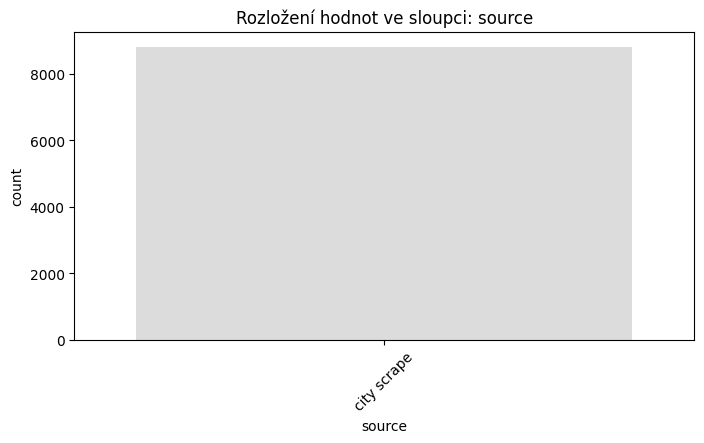

/var/folders/c2/5t4vwc1n1jdcwd15x4d_69cm0000gn/T/ipykernel_88272/3519055713.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


KeyboardInterrupt: 

In [30]:


# Vykreslení grafů pro každý kategorický sloupec
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)
    plt.xticks(rotation=45)  # Natočení popisků pro lepší čitelnost
    plt.title(f"Rozložení hodnot ve sloupci: {col}")
    plt.show()

In [133]:
df= df.dropna(subset=["price"])

In [134]:
X = df.drop("price",axis=1)
y = df["price"]

In [137]:
X.head()

host_since  host_response_rate  host_acceptance_rate  host_listings_count  \
0      2008.0                 1.0                  1.00                 72.0   
1      2010.0                 1.0                  0.98                  4.0   
2      2012.0                 1.0                  0.80                  6.0   
3      2012.0                 1.0                  0.80                  6.0   
4      2012.0                 1.0                  0.80                  6.0   

   host_total_listings_count  accommodates  bathrooms  bedrooms  beds  \
0                       82.0             4        1.0       1.0   2.0   
1                        4.0             4        1.5       1.0   2.0   
2                        6.0             2        1.0       1.0   2.0   
3                        6.0             2        1.0       1.0   3.0   
4                        6.0             2        1.0       1.0   1.0   

   minimum_nights  maximum_nights  minimum_minimum_nights  \
0               1             365                       1   
1               3             700                       3   
2               3              60                       1   
3               3              60                       3   
4               3              60                       3   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                       7                      60                     731   
1                       4                    1125                    1125   
2                       3                      60                      60   
3                       3                      60                      60   
4                       3                      60                      60   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  availability_30  \
0                     1.4                   663.6                0   
1                     3.1                  1125.0                3   
2                     3.0                    60.0                5   
3                     3.0                    60.0                3   
4                     3.0                    60.0                6   

   availability_60  availability_90  availability_365  number_of_reviews  \
0                0                0                 0                 31   
1                7               24               173                411   
2                5                5                 5                414   
3                3                3                 3                389   
4                6                6                 6                381   

   number_of_reviews_ltm  number_of_reviews_l30d  availability_eoy  \
0                      1                       0                 0   
1                     53                       3               173   
2                     52                       5                 5   
3                     47                       3                 3   
4                     52                       2                 6   

   number_of_reviews_ly  estimated_occupancy_l365d  estimated_revenue_l365d  \
0                     1                          6                  17508.0   
1                    57                        255                 403410.0   
2                    52                        255                 219300.0   
3                    48                        255                 160395.0   
4                    53                        255                 196860.0   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  4.90                    4.83                       5.00   
1                  4.94                    4.95                       4.92   
2                  4.76                    4.85                       4.71   
3                  4.69                    4.79                       4.58   
4                  4.78                    4.90                       4.64   

   review_

In [183]:
X.columns = X.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)


In [182]:
for col in numerical_columns:
    X[col] = X[col].replace('NA', np.nan)
print(X.isnull().sum())


host_since                     1
host_response_rate           562
host_acceptance_rate         272
host_listings_count            1
host_total_listings_count      1
                            ... 
Dishwasher_1                   0
Washer_1                       0
Wineglasses_1                  0
Petsallowed_1                  0
Patioorbalcony_1               0
Length: 3963, dtype: int64


In [36]:
len(X.columns)

3280

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), timeout=480, show_progress_bar=True)


# Získání nejlepšího modelu a imputérů
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]
num_imputer = best_trial.user_attrs["imputers"]
# přidat one hot encoding, škálování 


# Transformace testovacích dat
X_test_transformed = num_imputer.transform(X_test)


# Predikce
y_pred = best_model.predict(X_test_transformed)


[I 2025-04-19 17:29:09,768] A new study created in memory with name: no-name-63e53f61-4fcb-4adc-a969-37a59e954ad3


   0%|          | 00:00/08:00

Testing trial with params: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.08117267274156607, 'tree_method': 'hist', 'random_state': 42, 'verbosity': 0, 'n_jobs': -1}
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
trained
[W 2025-04-19 17:30:46,107] Trial 0 failed with parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.08117267274156607} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/c2/5t4vwc1n1jdcwd15x4d_69cm0000gn/T/ipykernel_89860/2153604198.py", line 7, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train), timeout=480, show_progre

KeyboardInterrupt: 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
X_train.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',

In [ ]:
print(X_test.head())

                       id  listing_url       scrape_id  last_scraped  source  \
1886             22900681         4696  20250316041547             0       0   
4007             53492952         7079  20250316041547             0       0   
3118             41994013         6153  20250316041547             0       0   
9513  1312995727830590411         3030  20250316041547             0       0   
8845  1257149893814943644         2336  20250316041547             0       0   

      name  description  neighborhood_overview  picture_url    host_id  \
1886  5387         3099                   2919          440  169479007   
4007    45         2280                   2919         7342    3736234   
3118  4030         6498                   2919         2993  239244930   
9513  8377         2296                    515         9486   78765288   
8845  8074         7895                   1347         9406  577476998   

      host_url  host_name  host_since  host_location  host_about  \
1886  

In [ ]:
X_train = outlier_remover(X, X_train)

In [ ]:
numerical_imputer = NumericalImputer()
categorical_imputer = CategoricalImputer()

print(X_train.isnull().sum())
print(X_test.isnull().sum())

KeyboardInterrupt: 

In [ ]:

# vše kromě nejspíš logaritmovaného sloupce
excluded_column = 'column_to_exclude'
columns_to_scale = numerical_columns[numerical_columns != excluded_column]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', numerical_imputer),  
            ('scaler', StandardScaler())     
        ]), columns_to_scale),  
        
        ('cat', categorical_imputer, X.select_dtypes(include=['object']).columns) 
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

NameError: name 'numerical_columns' is not defined